#About Me

- Nama : Maulia Savana Putri
- Email : mauliasavana72@gmail.com

#About Data

Perform Text Classification on the data. The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.

Columns:
- Location
- Tweet At
- Original Tweet
- Label

Link to download: https://drive.google.com/file/d/1NbdAbGSL0fgFe5FAL4rNqCB2Hv_EPPy4/view?usp=sharing

#Import and Load Data

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import  re
import string
import nltk
nltk.download("stopwords") 
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('/content/Corona_NLP.csv', encoding='latin_1')
df = df[['OriginalTweet', 'Sentiment']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  44955 non-null  object
 1   Sentiment      44955 non-null  object
dtypes: object(2)
memory usage: 702.5+ KB


In [6]:
df.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


#Preprocessing Data

##One Hot Encoding

In [7]:
category = pd.get_dummies(df.Sentiment)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Sentiment')
df_baru

,OriginalTweet,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,TRENDING: New Yorkers encounter empty supermar...,1,0,0,0,0
1,When I couldn't find hand sanitizer at Fred Me...,0,0,0,0,1
2,Find out how you can protect yourself and love...,0,1,0,0,0
3,#Panic buying hits #NewYork City as anxious sh...,0,0,1,0,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0,0,0,1,0
...,...,...,...,...,...,...
44950,Airline pilots offering to stock supermarket s...,0,0,0,1,0
44951,Response to complaint not provided citing COVI...,1,0,0,0,0
44952,You know itÂs getting tough when @KameronWild...,0,0,0,0,1
44953,Is it wrong that the smell of hand sanitizer i...,0,0,0,1,0


##Cleaning Data

In [8]:
stop_words = stopwords.words("english")

In [9]:
# clean unwanted text like stopwords, @(Mention), https(url), #(Hashtag), punctuations
def removeUnwantedText(text):
    #remove urls
    text = re.sub(r'http\S+', " ", text)
    
    #remove mentions
    text = re.sub(r'@\w+',' ',text)
    
    #remove hastags
    text = re.sub(r'#\w+', ' ', text)
    
    #remove html tags
    text = re.sub('r<.*?>',' ', text)
    
     #remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    
    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    return text

In [10]:
df_baru['OriginalTweet'] = df_baru['OriginalTweet'].apply(lambda x: removeUnwantedText(x))

##Separate attributes and labels

In [11]:
tweet = df_baru['OriginalTweet'].values
label = df_baru[['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']].values

In [12]:
from sklearn.model_selection import train_test_split
tweet_latih, tweet_test, label_latih, label_test = train_test_split(tweet, label, test_size=0.2)

#Tokenization and Sequences

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(tweet_latih) 
tokenizer.fit_on_texts(tweet_test)
 
sekuens_latih = tokenizer.texts_to_sequences(tweet_latih)
sekuens_test = tokenizer.texts_to_sequences(tweet_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

#Architectural Model

In [37]:
model = tf.keras.Sequential([
    Embedding(input_dim=10000, output_dim=16),
    LSTM(512, dropout=0.5),
    tf.keras.layers.Flatten(),
    Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#Callbacks

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [38]:
num_epochs = 20
history = model.fit(padded_latih, label_latih, batch_size=256, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/20
141/141 - 253s - loss: 1.5560 - accuracy: 0.2881 - val_loss: 1.4742 - val_accuracy: 0.3074
Epoch 2/20
141/141 - 258s - loss: 1.2206 - accuracy: 0.4880 - val_loss: 1.0349 - val_accuracy: 0.5821
Epoch 3/20
141/141 - 259s - loss: 0.9306 - accuracy: 0.6270 - val_loss: 0.8511 - val_accuracy: 0.6815
Epoch 4/20
141/141 - 255s - loss: 0.7913 - accuracy: 0.6925 - val_loss: 0.7603 - val_accuracy: 0.7256
Epoch 5/20
141/141 - 252s - loss: 0.7131 - accuracy: 0.7338 - val_loss: 0.7321 - val_accuracy: 0.7366
Epoch 6/20
141/141 - 252s - loss: 0.6650 - accuracy: 0.7553 - val_loss: 0.7095 - val_accuracy: 0.7493
Epoch 7/20
141/141 - 251s - loss: 0.6384 - accuracy: 0.7683 - val_loss: 0.6911 - val_accuracy: 0.7592
Epoch 8/20
141/141 - 255s - loss: 0.5994 - accuracy: 0.7826 - val_loss: 0.6857 - val_accuracy: 0.7583
Epoch 9/20
141/141 - 260s - loss: 0.5817 - accuracy: 0.7908 - val_loss: 0.6775 - val_accuracy: 0.7688
Epoch 10/20
141/141 - 254s - loss: 0.5601 - accuracy: 0.8000 - val_loss: 0.6771 - 

#Plot Loss and Accuracy

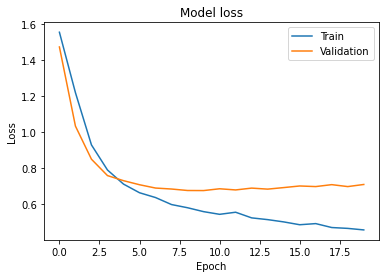

In [39]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

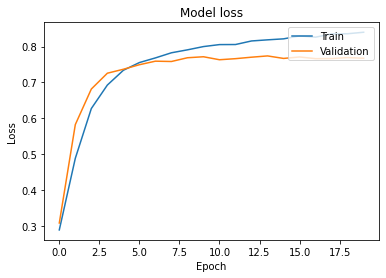

In [40]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()